In [35]:
import os
from pathlib import Path
import numpy as np
import torch
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from src.data_modules import HSIDermoscopyDataModule
from src.data_modules.datasets.hsi_dermoscopy_dataset import HSIDermoscopyDataset


In [36]:
config = {
    "task": "GENERATION",
    "allowed_labels": ["melanoma"],
    "train_val_test_split": (0.7, 0.15, 0.15),
    "image_size": 64,
    "batch_size": 2,
    "num_workers": 8,
    "pin_memory": True,
    "data_dir": "data/hsi_dermoscopy_croppedv2_256",
    "google_drive_id": "1EnDjh_tNlVDNUyPuFzyZ_rJNOzTcLeB3",
    "balanced_sampling": True,
    "global_max": [
        0.6203158, 0.6172642, 0.46794897, 0.4325111, 0.4996644, 0.61997396,
        0.7382196, 0.86097705, 0.88304037, 0.9397393, 1.1892519, 1.5035477,
        1.4947973, 1.4737314, 1.6318618, 1.7226081
    ],
    "global_min": [
        0.00028473, 0.0043945, 0.00149752, 0.00167517, 0.00190101, 0.0028114,
        0.00394378, 0.00488099, 0.00257091, 0.00215704, 0.00797662, 0.01205248,
        0.01310135, 0.01476806, 0.01932094, 0.02020744
    ],
    "transforms": {
        "train": [
            {"class_path": "SmallestMaxSize", "init_args": {"max_size": 64}},
            {"class_path": "CenterCrop", "init_args": {"height": 64, "width": 64}},
            {"class_path": "ToTensorV2", "init_args": {}},
        ],
        "val": [
            {"class_path": "SmallestMaxSize", "init_args": {"max_size": 64}},
            {"class_path": "CenterCrop", "init_args": {"height": 64, "width": 64}},
            {"class_path": "ToTensorV2", "init_args": {}},
        ],
        "test": [
            {"class_path": "SmallestMaxSize", "init_args": {"max_size": 64}},
            {"class_path": "CenterCrop", "init_args": {"height": 64, "width": 64}},
            {"class_path": "ToTensorV2", "init_args": {}},
        ],
    },
}

print("✅ Config loaded.")


✅ Config loaded.


In [37]:
data_module = HSIDermoscopyDataModule(**config)
print(data_module)
print("✅ Data module initialized.")

{Train dataloader: None}
{Validation dataloader: size=NA}
{Test dataloader: size=NA}
{Predict dataloader: None}
✅ Data module initialized.


In [38]:

print("Training transforms:", data_module.transforms_train)
print("Validation transforms:", data_module.transforms_val)
print("Test transforms:", data_module.transforms_test)


Training transforms: Compose([
  SmallestMaxSize(p=1.0, area_for_downscale=None, interpolation=1, mask_interpolation=0, max_size=64, max_size_hw=None),
  CenterCrop(p=1.0, border_mode=0, fill=0.0, fill_mask=0.0, height=64, pad_if_needed=False, pad_position='center', width=64),
  ToTensorV2(p=1.0, transpose_mask=False),
  NormalizeByMinMax(p=1.0, clip=True, maxs=tensor([0.6203, 0.6173, 0.4679, 0.4325, 0.4997, 0.6200, 0.7382, 0.8610, 0.8830,
        0.9397, 1.1893, 1.5035, 1.4948, 1.4737, 1.6319, 1.7226]), mins=tensor([0.0003, 0.0044, 0.0015, 0.0017, 0.0019, 0.0028, 0.0039, 0.0049, 0.0026,
        0.0022, 0.0080, 0.0121, 0.0131, 0.0148, 0.0193, 0.0202]), range_mode='-1_1'),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True, seed=None)
Validation transforms: Compose([
  SmallestMaxSize(p=1.0, area_for_downscale=None, interpolation=1, mask_interpolation=0, max_size=64, max_size_hw=None),
  CenterCrop(p=1.0, border_mode=0, fill=0.0, fill_mask=0.0,

In [39]:

data_module.prepare_data()
print("✅ Data prepared.")
print("Dataset directory:", os.listdir(config["data_dir"])[:10])

Downloading...
From (original): https://drive.google.com/uc?id=1EnDjh_tNlVDNUyPuFzyZ_rJNOzTcLeB3
From (redirected): https://drive.google.com/uc?id=1EnDjh_tNlVDNUyPuFzyZ_rJNOzTcLeB3&confirm=t&uuid=a71ef9a0-76ec-4599-81ed-cf70cf9ed4d1
To: /mnt/datahdd/kris_volume/dgm-2025.2/projects/hyperskin/src/hsi_dermoscopy_croppedv2_256.zip
100%|██████████| 1.04G/1.04G [01:33<00:00, 11.2MB/s]


✅ Data prepared.
Dataset directory: ['path_mapping.csv', 'images', 'metadata.csv']


In [40]:

data_dir = Path(config["data_dir"])
items = list(data_dir.iterdir())
print(f"📁 Dataset directory: {data_dir}")
for item in items:
    print(" -", item.name)

if (data_dir / "metadata.csv").exists():
    print("\n📄 Preview of metadata.csv:")
    metadata_df = pd.read_csv(data_dir / "metadata.csv")
    display(metadata_df.head())

if (data_dir / "path_mapping.csv").exists():
    print("\n📄 Preview of path_mapping.csv:")
    mapping_df = pd.read_csv(data_dir / "path_mapping.csv")
    display(mapping_df.head())

images_dir = data_dir / "images"
if images_dir.exists():
    print("\n🖼️ Example files inside 'images/' folder:")
    img_files = list(images_dir.glob("*"))[:10]
    for img in img_files:
        print(" -", img.name)

print(len(metadata_df), "total samples in metadata.csv")

📁 Dataset directory: data/hsi_dermoscopy_croppedv2_256
 - path_mapping.csv
 - images
 - metadata.csv

📄 Preview of metadata.csv:


,file_path,label,masks
0,data/hsi_dermoscopy_croppedv2_256/images/DNCub...,dysplastic_nevi,NaN
1,data/hsi_dermoscopy_croppedv2_256/images/DNCub...,dysplastic_nevi,NaN
2,data/hsi_dermoscopy_croppedv2_256/images/DNCub...,dysplastic_nevi,NaN
3,data/hsi_dermoscopy_croppedv2_256/images/DNCub...,dysplastic_nevi,NaN
4,data/hsi_dermoscopy_croppedv2_256/images/DNCub...,dysplastic_nevi,NaN



📄 Preview of path_mapping.csv:


,Unnamed: 0,original_path
0,export/hsi_dermoscopy_croppedv2_256/images/DNC...,data/hsi_dermoscopy/images/DNCube/21.mat
1,export/hsi_dermoscopy_croppedv2_256/images/DNC...,data/hsi_dermoscopy/images/DNCube/141.mat
2,export/hsi_dermoscopy_croppedv2_256/images/MMC...,data/hsi_dermoscopy/images/MMCube/36.mat
3,export/hsi_dermoscopy_croppedv2_256/images/DNC...,data/hsi_dermoscopy/images/DNCube/129.mat
4,export/hsi_dermoscopy_croppedv2_256/images/DNC...,data/hsi_dermoscopy/images/DNCube/162.mat



🖼️ Example files inside 'images/' folder:
 - DNCube
 - MMCube
 - OtherCube
290 total samples in metadata.csv


In [41]:
from src.data_modules.datasets.hsi_dermoscopy_dataset import HSIDermoscopyDataset, HSIDermoscopyTask

dataset = HSIDermoscopyDataset(
    task=HSIDermoscopyTask.GENERATION,  # same task you used in your config
    data_dir="data/hsi_dermoscopy_cropped"
)


unique_labels = dataset.labels_df["label"].unique()
print("🩺 Unique labels in dataset:", unique_labels)
print(f"Total samples in metadata.csv: {len(dataset.labels_df)}")

print("\n🔢 Label mapping (dataset.labels_map):")
for k, v in dataset.labels_map.items():
    print(f"  {k:25s} -> {v}")


dataset_indices = np.arange(len(dataset))
dataset_labels = dataset.labels_df["label"].map(dataset.labels_map).to_numpy()


🩺 Unique labels in dataset: ['dysplastic_nevi' 'melanoma' 'melanocytic_lesion' 'nevi' 'solar_lentigo'
 'interepidermal_carcinoma']
Total samples in metadata.csv: 312

🔢 Label mapping (dataset.labels_map):
  dysplastic_nevi           -> 0
  melanoma                  -> 1
  solar_lentigo             -> 2
  interepidermal_carcinoma  -> 3
  nevi                      -> 4
  seborrheic_keratosis      -> 5
  melanocytic_lesion        -> 6


In [42]:
split_dir = Path(config["data_dir"]).parent / "splits"
for name in ["train.txt", "val.txt", "test.txt"]:
    path = split_dir / name
    if path.exists():
        data = np.loadtxt(path, dtype=int)
        print(f"{name}: {len(data)} samples")



data_module.setup()
print(f"Train samples: {len(data_module.data_train)}")
print(f"Val samples: {len(data_module.data_val)}")
print(f"Test samples: {len(data_module.data_test)}")

Train samples: 67
Val samples: 15
Test samples: 15


In [43]:
dataset = data_module.data_train.dataset if hasattr(data_module.data_train, 'dataset') else data_module.data_train
print("Labels map:", dataset.labels_map)
print(dataset.labels_df.head())

Labels map: {'dysplastic_nevi': 0, 'melanoma': 1, 'solar_lentigo': 2, 'interepidermal_carcinoma': 3, 'nevi': 4, 'seborrheic_keratosis': 5, 'melanocytic_lesion': 6}
                                           file_path            label  masks
0  data/hsi_dermoscopy_croppedv2_256/images/DNCub...  dysplastic_nevi    NaN
1  data/hsi_dermoscopy_croppedv2_256/images/DNCub...  dysplastic_nevi    NaN
2  data/hsi_dermoscopy_croppedv2_256/images/DNCub...  dysplastic_nevi    NaN
3  data/hsi_dermoscopy_croppedv2_256/images/DNCub...  dysplastic_nevi    NaN
4  data/hsi_dermoscopy_croppedv2_256/images/DNCub...  dysplastic_nevi    NaN


Type of image: <class 'torch.Tensor'>, shape: torch.Size([16, 64, 64])
Type of label: <class 'torch.Tensor'>, value: 0


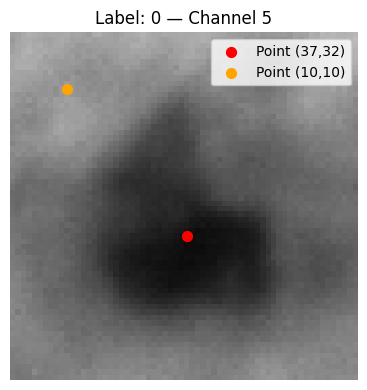

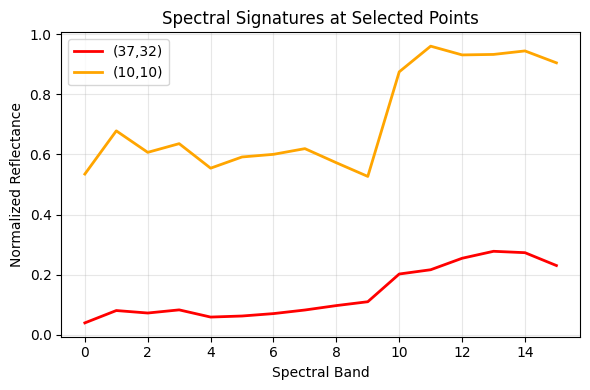

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1️⃣ Sample random image from dataset
# ============================================================
idx = np.random.randint(0, len(dataset))
image, label = dataset[idx]

print(f"Type of image: {type(image)}, shape: {image.shape}")
print(f"Type of label: {type(label)}, value: {label.item() if label.ndim == 0 else label}")

# ============================================================
# 2️⃣ Normalize from [-1, 1] → [0, 1]
# ============================================================
if image.min() < 0:
    image = (image + 1) / 2

# Clamp just in case
image = np.clip(image, 0, 1)

# ============================================================
# 3️⃣ Plot selected spectral band with highlighted pixels
# ============================================================
channel = 5   # choose between 0–15 for your HSI data
x, y = 37, 32 # primary point
x2, y2 = 10, 10 # secondary point for comparison

plt.figure(figsize=(4, 4))
plt.imshow(image[channel, ...], cmap='gray', vmin=0, vmax=1)
plt.scatter([y], [x], color='red', s=50, marker='o', label=f'Point ({x},{y})')
plt.scatter([y2], [x2], color='orange', s=50, marker='o', label=f'Point ({x2},{y2})')
plt.title(f"Label: {label.item()} — Channel {channel}")
plt.axis("off")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# ============================================================
# 4️⃣ Plot spectral signatures at both points
# ============================================================
spectral_values_1 = image[:, x, y]
spectral_values_2 = image[:, x2, y2]

plt.figure(figsize=(6, 4))
plt.plot(np.arange(image.shape[0]), spectral_values_1, color='red', linewidth=2, label=f'({x},{y})')
plt.plot(np.arange(image.shape[0]), spectral_values_2, color='orange', linewidth=2, label=f'({x2},{y2})')
plt.title("Spectral Signatures at Selected Points")
plt.xlabel("Spectral Band")
plt.ylabel("Normalized Reflectance")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

batch = next(iter(train_loader))
if isinstance(batch, dict):
    print("Batch keys:", batch.keys())
    if 'image' in batch:
        print("Image batch shape:", batch['image'].shape)
else:
    print(type(batch))


Train batches: 55
Val batches: 12
Test batches: 12
<class 'list'>


In [26]:
from pprint import pprint

print("🧩 Training Transform Pipeline:")
for i, t in enumerate(data_module.transforms_train.transforms):
    print(f"{i+1}. {t.__class__.__name__}")
    pprint(vars(t))


🧩 Training Transform Pipeline:
1. SmallestMaxSize
{'_additional_targets': {},
 '_available_keys': {'bboxes',
                     'image',
                     'images',
                     'keypoints',
                     'mask',
                     'mask3d',
                     'masks',
                     'masks3d',
                     'volume',
                     'volumes'},
 '_key2func': {'bboxes': <bound method MaxSizeTransform.apply_to_bboxes of SmallestMaxSize(p=1.0, area_for_downscale=None, interpolation=1, mask_interpolation=0, max_size=256, max_size_hw=None)>,
               'image': <bound method MaxSizeTransform.apply of SmallestMaxSize(p=1.0, area_for_downscale=None, interpolation=1, mask_interpolation=0, max_size=256, max_size_hw=None)>,
               'images': <bound method MaxSizeTransform.apply_to_images of SmallestMaxSize(p=1.0, area_for_downscale=None, interpolation=1, mask_interpolation=0, max_size=256, max_size_hw=None)>,
               'keypoints': <boun

Raw image shape: (217, 427, 16)


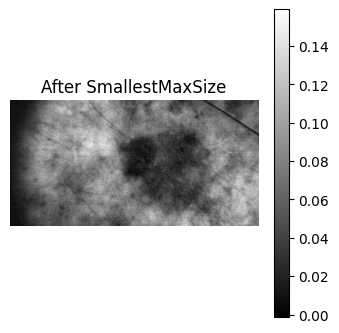

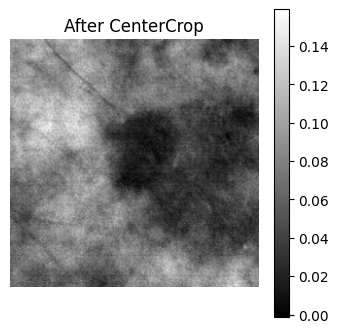

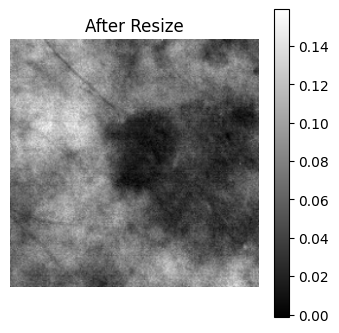

In [29]:
import albumentations as A

# Reload one raw sample from your dataset
raw_dataset = HSIDermoscopyDataset(
    task=data_module.hparams.task,
    data_dir=config["data_dir"]
)

raw_image, raw_label = raw_dataset[0]
print(f"Raw image shape: {raw_image.shape}")

# Albumentations expects numpy, ensure it’s float32
img_np = np.array(raw_image, dtype=np.float32)

# Get individual transforms from your pipeline
tforms = data_module.transforms_train.transforms

# Apply transforms incrementally
current = {"image": img_np}
for i, transform in enumerate(tforms, 1):
    transformed = transform(**current)
    img_transformed = transformed["image"]

    # Visualize
    plt.figure(figsize=(4, 4))
    plt.imshow(img_transformed[..., 0] if img_transformed.ndim == 3 else img_transformed, cmap="gray")
    plt.title(f"After {transform.__class__.__name__}")
    plt.axis("off")
    plt.colorbar()
    plt.show()

    current = transformed  # feed next transform


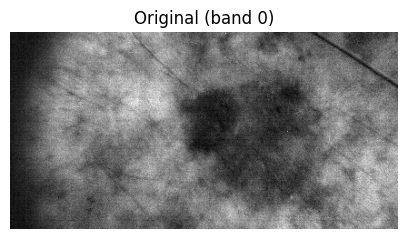

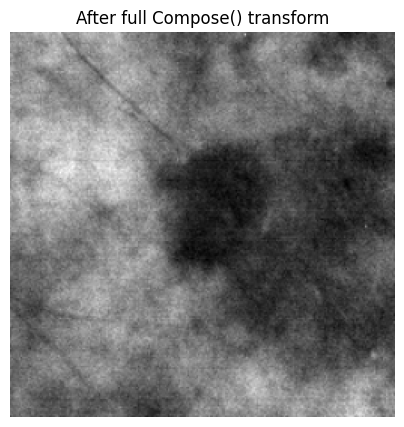

Original shape: (217, 427, 16), After transform: (256, 256, 16)


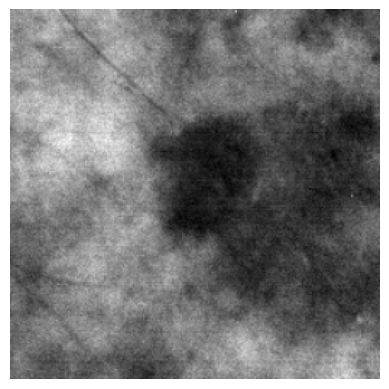

In [ ]:
import matplotlib.animation as animation
# Full composed transform
compose_train = data_module.transforms_train

# Original raw image
plt.figure(figsize=(5, 5))
plt.imshow(img_np[..., 0], cmap="gray")
plt.title("Original (band 0)")
plt.axis("off")
plt.show()

# Transformed image
out = compose_train(image=img_np)
img_after = out["image"]

plt.figure(figsize=(5, 5))
plt.imshow(img_after[..., 0] if img_after.ndim == 3 else img_after, cmap="gray")
plt.title("After full Compose() transform")
plt.axis("off")
plt.colorbar()
plt.show()

print(f"Original shape: {img_np.shape}, After transform: {img_after.shape}")

fig, ax = plt.subplots()
im = ax.imshow(img_after[..., 0], cmap='gray')
ax.axis('off')

def update(i):
    im.set_array(img_after[..., i])
    ax.set_title(f"Band {i}")
    return [im]

ani = animation.FuncAnimation(fig, update, frames=img_after.shape[2], interval=400)
plt.show()


In [ ]:

ani = animation.FuncAnimation(fig, update, frames=img_after.shape[2], interval=400)
plt.show()
ani.save("hyperspectral_animation.gif", writer="pillow", fps=2)
from IPython.display import Image
Image(filename="hyperspectral_animation.gif")


In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image

# === Import your trained module ===
from src.modules.generative.gan.wgan_teste import WGANModule  # adjust path if needed

# === Path to checkpoint ===
# ckpt_path = "/mnt/datahdd/kris_volume/dgm-2025.2/projects/hyperskin/logs/hypersynth/xm4m6lfx/checkpoints/last.ckpt"
# ckpt_path = "/mnt/datahdd/kris_volume/dgm-2025.2/projects/hyperskin/logs/hypersynth/pn1661js/checkpoints/epoch=94-val/g_loss=-0.0115.ckpt"
ckpt_path = "/mnt/datahdd/kris_volume/dgm-2025.2/projects/hyperskin/logs/hypersynth/its43r14/checkpoints/last.ckpt"
# === Load model ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = WGANModule.load_from_checkpoint(ckpt_path, map_location=device)

# === Extract generator ===
generator = model.G.to(device).eval()

z = torch.randn(1, model.hparams.latent_dim, model.hparams.img_size, model.hparams.img_size, device=device)

# === Generate image ===
with torch.no_grad():
    fake_img = generator(z)


for i in range(fake_img.shape[1]):
    print(fake_img.shape)  # should be [1, img_channels, img_size, img_size]    
    print(fake_img.min().item(), fake_img.max().item())

    fake_img = fake_img.squeeze(0)  # remove batch dimension
    vals = fake_img[i].detach().cpu().numpy().ravel()

    plt.figure(figsize=(6, 4))
    plt.hist(vals, bins=100, color='gray', edgecolor='black')
    plt.title(f"Histogram of fake_img channel {i}")
    plt.xlabel("Pixel value")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()

    print(f"mean={vals.mean():.4f}, std={vals.std():.4f}, min={vals.min():.4f}, max={vals.max():.4f}")
    # fake_img = (fake_img.clamp(-1, 1) + 1) / 2
    # grid = make_grid(fake_img, nrow=1)

    # fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    # for i, ax in enumerate(axes.flat):
    #     if i < fake_img.shape[1]:
    #         ax.imshow(fake_img[0, i].cpu(), cmap='gray')
    #         ax.set_title(f"Ch {i}")
    #     ax.axis("off")
    # plt.tight_layout()
    # plt.show()



Generated image shape: (16, 64, 64)


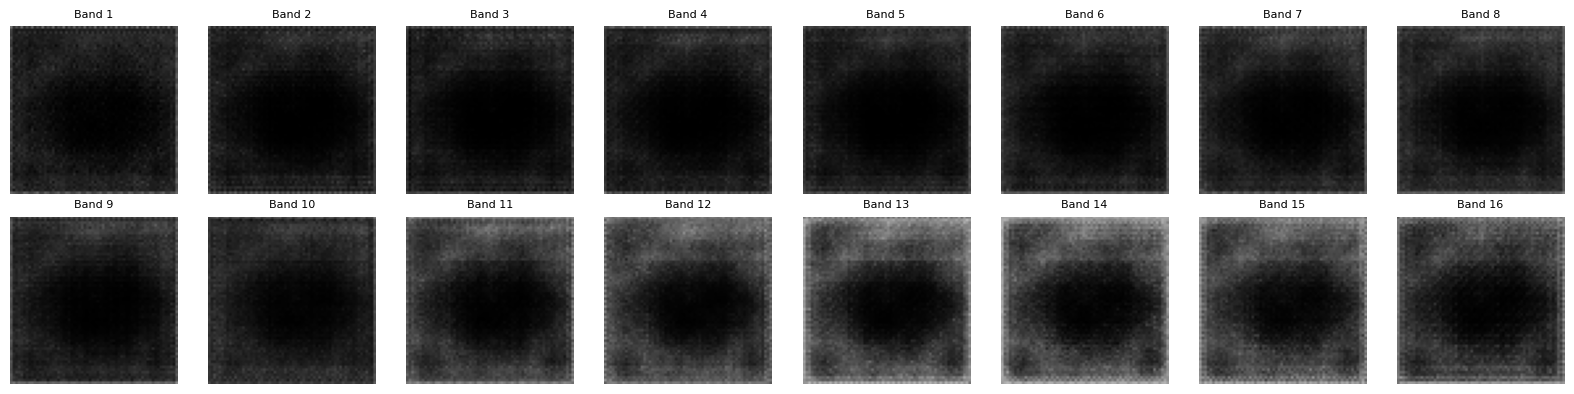

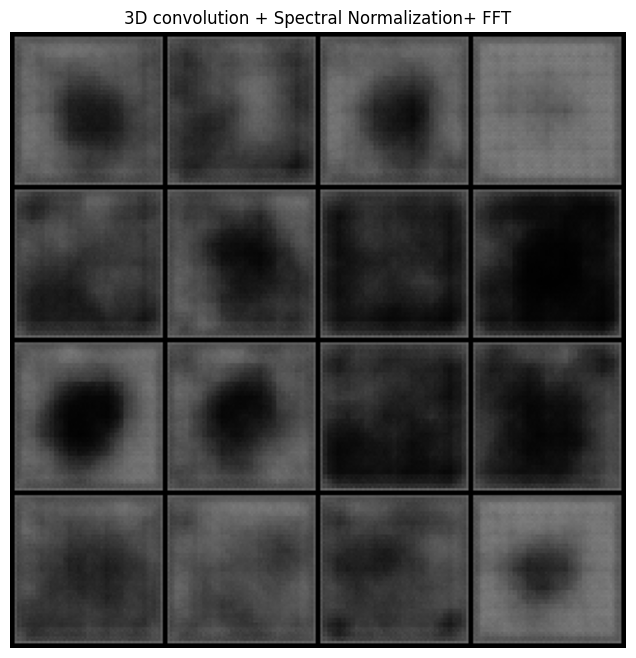

In [92]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from src.modules.generative.gan.wgan_teste import WGANModule

# ============================================================
# 1️⃣ Load model checkpoint
# ============================================================
# ckpt_path = "/mnt/datahdd/kris_volume/dgm-2025.2/projects/hyperskin/logs/hypersynth/u588bskp/checkpoints/last.ckpt"
ckpt_path = "/mnt/datahdd/kris_volume/dgm-2025.2/projects/hyperskin/logs/hypersynth/ihgl71pn/checkpoints/last.ckpt"
model = WGANModule.load_from_checkpoint(ckpt_path, map_location="cpu", strict=False)
G = model.G.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = G.to(device)

# ============================================================
# 2️⃣ Sample latent vector and generate fake image
# ============================================================
latent_dim = model.hparams.latent_dim
z = torch.randn(1, latent_dim, 1, 1, device=device)

with torch.no_grad():
    fake = G(z).cpu().squeeze(0)  # [C, H, W]

print(f"Generated image shape: {tuple(fake.shape)}")

# ============================================================
# 3️⃣ Plot each spectral channel (your original code)
# ============================================================
num_channels = fake.shape[0]
cols = 8
rows = (num_channels + cols - 1) // cols

plt.figure(figsize=(2 * cols, 2 * rows))
for i in range(num_channels):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(fake[i], cmap="gray", vmin=-1, vmax=1)
    plt.title(f"Band {i+1}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()



z = torch.randn(16, latent_dim, 1, 1, device=device)
with torch.no_grad():
    fake_batch = G(z).cpu()  # [16, C, H, W]


fake_display = fake_batch.mean(dim=1, keepdim=True).repeat(1, 3, 1, 1)  # [16, 3, H, W]

# Create grid like WandB does
from torchvision.utils import make_grid
grid = make_grid(fake_display, nrow=4, normalize=True, value_range=(-1, 1))

plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.title("3D convolution + Spectral Normalization+ FFT")
plt.axis("off")

plt.show()


In [58]:
import torch
from src.modules.generative.gan.wgan_teste import WGANModule

def generate_fake_from_ckpt(z, ckpt_path: str, device: str | torch.device = "cuda") -> torch.Tensor:
    """
    Loads a WGANModule checkpoint and generates a single fake image tensor.
    
    Args:
        ckpt_path (str): Path to the checkpoint (.ckpt) file.
        device (str or torch.device): "cuda" or "cpu".
        
    Returns:
        torch.Tensor: Generated fake image tensor of shape [C, H, W], on CPU.
    """
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model = WGANModule.load_from_checkpoint(ckpt_path, map_location="cpu", strict=False)
    G = model.G.eval().to(device)
    with torch.no_grad():
        fake = G(z).cpu().squeeze(0)  # shape [C, H, W]

    return fake


/mnt/datahdd/aline_conda/miniconda3/envs/hyperskin/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['D.model.0.0.weight', 'D.model.1.0.weight', 'D.model.1.1.weight', 'D.model.1.1.bias', 'D.model.1.1.running_mean', 'D.model.1.1.running_var', 'D.model.2.0.weight', 'D.model.2.1.weight', 'D.model.2.1.bias', 'D.model.2.1.running_mean', 'D.model.2.1.running_var', 'D.model.3.0.weight', 'D.model.3.1.weight', 'D.model.3.1.bias', 'D.model.3.1.running_mean', 'D.model.3.1.running_var', 'D.model.4.0.weight']
/mnt/datahdd/aline_conda/miniconda3/envs/hyperskin/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['D.model.5.weight', 'D.model.5.bias', 'D.model.6.weight', 'D.model.6.bias', 'D.model.6.running_mean', 'D.model.6.running_var', 'D.model.6.num_batches_tracked', 'D.model.8.weight', 'D.model.8.bias', 'D.model.9.weight', '

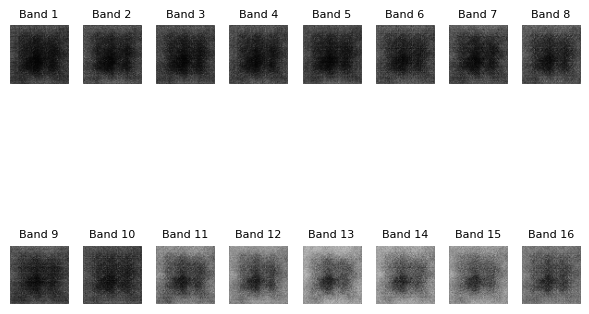

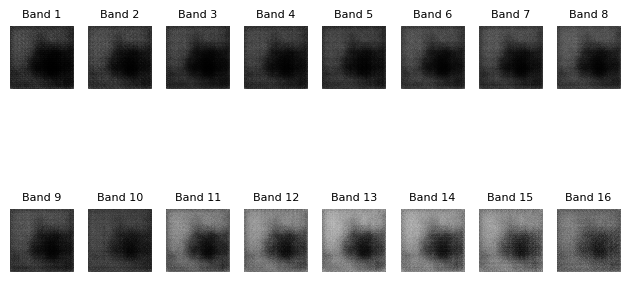

In [ ]:
conv2d_path = "/mnt/datahdd/kris_volume/dgm-2025.2/projects/hyperskin/logs/hypersynth/hxchxcy5/checkpoints/epoch=183-val/g_loss=-452.1470.ckpt"
conv3d_path = "/mnt/datahdd/kris_volume/dgm-2025.2/projects/hyperskin/logs/hypersynth/db6vkgfn/checkpoints/epoch=122-val/g_loss=-1116.0297.ckpt"
latent_dim = model.hparams.latent_dim
z = torch.randn(1, latent_dim, 1, 1, device=device)

fake_image_1 = generate_fake_from_ckpt(z, conv2d_path, device="cuda")
fake_image_2 = generate_fake_from_ckpt(z, conv3d_path, device="cuda")


cols = 8
rows = 2 * ((fake_image_1.shape[0] + cols - 1) // cols)
plt.figure(figsize=(8, 6))

# --- first row: conv2d bands ---
for i in range(fake_image_1.shape[0]):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(fake_image_1[i].cpu(), cmap="gray", vmin=-1, vmax=1)
    plt.title(f"2D Band {i+1}", fontsize=7)
    plt.axis("off")

# --- second row: conv3d bands ---
offset = fake_image_1.shape[0]
for i in range(fake_image_2.shape[0]):
    plt.subplot(rows, cols, offset + i + 1)
    plt.imshow(fake_image_2[i].cpu(), cmap="gray", vmin=-1, vmax=1)
    plt.title(f"3D Band {i+1}", fontsize=7)
    plt.axis("off")

plt.tight_layout(pad=0.2)
plt.show()

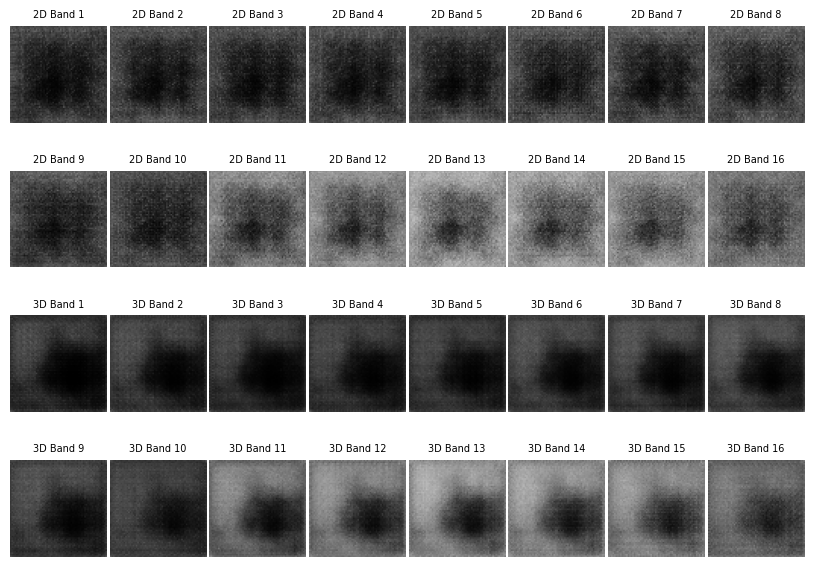

In [60]:
cols = 8
rows = 2 * ((fake_image_1.shape[0] + cols - 1) // cols)
plt.figure(figsize=(8, 6))

# --- first row: conv2d bands ---
for i in range(fake_image_1.shape[0]):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(fake_image_1[i].cpu(), cmap="gray", vmin=-1, vmax=1)
    plt.title(f"2D Band {i+1}", fontsize=7)
    plt.axis("off")

# --- second row: conv3d bands ---
offset = fake_image_1.shape[0]
for i in range(fake_image_2.shape[0]):
    plt.subplot(rows, cols, offset + i + 1)
    plt.imshow(fake_image_2[i].cpu(), cmap="gray", vmin=-1, vmax=1)
    plt.title(f"3D Band {i+1}", fontsize=7)
    plt.axis("off")

plt.tight_layout(pad=0.2)
plt.show()

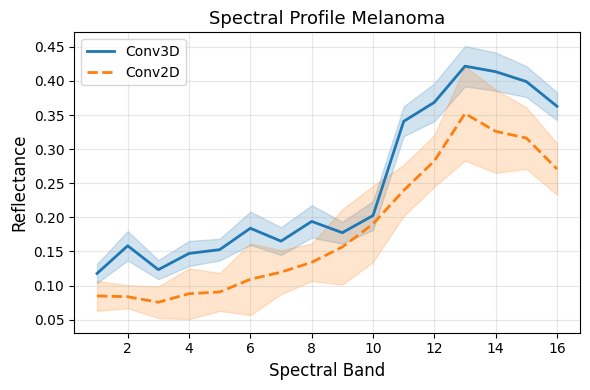

Center pixel coordinates: (x0=34, y0=36)


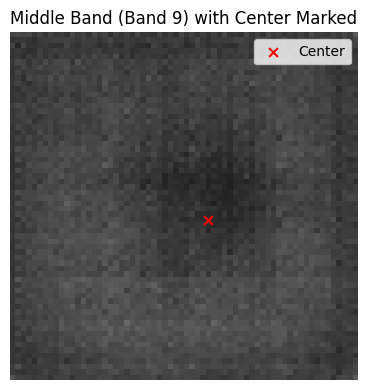

In [65]:
# ============================================================
# 4️⃣ Plot spectral signature at center pixel (normalized)
# ============================================================
C, H, W = fake.shape

# Normalize from [-1, 1] → [0, 1]
fake_norm = (fake + 1) / 2
fake_image_1_norm = (fake_image_1 + 1) / 2

# Center coordinates
x0, y0 = H // 2+ 2, W // 2 + 4

# Extract spectral profile (convert to numpy)
spectral_profile = fake_norm[:, x0, y0].numpy()
spectral_profile2 = fake_image_1_norm[:, x0, y0].numpy()

# Optionally compute small neighborhood mean ± std for smoother shading
patch = 3  # use a 3×3 neighborhood
half = patch // 2

def local_stats(img):
    region = img[:, x0-half:x0+half+1, y0-half:y0+half+1]
    mean = region.mean(axis=(1,2))
    std = region.std(axis=(1,2))
    return mean, std

mean1, std1 = local_stats(fake_norm.numpy())
mean2, std2 = local_stats(fake_image_1_norm.numpy())

bands = range(1, C + 1)

# ---- Plot ----
plt.figure(figsize=(6, 4))
plt.plot(bands, mean1, color='tab:blue', label='Conv3D', linewidth=2)
plt.fill_between(bands, mean1 - std1, mean1 + std1, color='tab:blue', alpha=0.2)

plt.plot(bands, mean2, color='tab:orange', linestyle='--', label='Conv2D', linewidth=2)
plt.fill_between(bands, mean2 - std2, mean2 + std2, color='tab:orange', alpha=0.2)

plt.xlabel("Spectral Band", fontsize=12)
plt.ylabel("Reflectance", fontsize=12)
plt.title("Spectral Profile Melanoma", fontsize=13)
plt.grid(alpha=0.3)
plt.legend(frameon=True)
plt.tight_layout()
plt.show()

print(f"Center pixel coordinates: (x0={x0}, y0={y0})")


# ============================================================
# 5️⃣ Show middle spectral band with center marker
# ============================================================
plt.figure(figsize=(4, 4))
plt.imshow(fake_norm[C // 2], cmap='gray', vmin=0, vmax=1)
plt.scatter(y0, x0, c='red', s=40, marker='x', label='Center')
plt.title(f"Middle Band (Band {C//2 + 1}) with Center Marked", fontsize=12)
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()
